# 🔍 V3 Advanced Model Analysis

> **V3 Notebook 04**  
> Comprehensive deep-dive into model performance, diagnostics, and interpretability.

---

## 🎯 Analysis Roadmap

| Section | Purpose |
|---------|---------|  
| **1. Model Loading** | Load trained V3 Climate Transformer |
| **2. Prediction Generation** | Generate forecasts on test set |
| **3. Global Metrics** | MAE, RMSE, and summary statistics |
| **4. Error Distribution** | Residual histogram and Q-Q plot |
| **5. Horizon Analysis** | Performance by forecast day (Day 1-7) |
| **6. Sample Forecasts** | Visual comparison: Actual vs Predicted |
| **7. Feature Importance** | GRN weight analysis |
| **8. Robustness Testing** | Handling missing Air Quality inputs |

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import joblib
from scipy import stats

# Styling
sns.set_theme(style="whitegrid", palette="husl")
plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 11,
    'axes.titlesize': 14,
    'axes.labelsize': 12
})

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'✅ Device: {device}')
print(f'🔧 PyTorch: {torch.__version__}')

✅ Device: cuda
🔧 PyTorch: 2.9.1+cu130


---
## 1️⃣ Load Model & Artifacts

In [2]:
# Model Architecture (must match training)
class GatedResidualNetwork(nn.Module):
    """GRN: Feature gating mechanism."""
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.2):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)
        self.gate = nn.Linear(hidden_dim, output_dim)
        self.layer_norm = nn.LayerNorm(output_dim)
        self.dropout = nn.Dropout(dropout)
        self.skip = nn.Linear(input_dim, output_dim) if input_dim != output_dim else None

    def forward(self, x):
        residual = self.skip(x) if self.skip else x
        h = self.dropout(torch.relu(self.fc1(x)))
        gate = torch.sigmoid(self.gate(h))
        return self.layer_norm(self.fc2(h) * gate + residual)

class V3ClimateTransformer(nn.Module):
    """Climate-Aware Transformer with GRN gates."""
    def __init__(self, input_dim, d_model=128, nhead=8, num_layers=4, dropout=0.2, seq_len=14, pred_len=7):
        super().__init__()
        self.input_grn = GatedResidualNetwork(input_dim, d_model * 2, d_model, dropout)
        self.pos_encoder = nn.Parameter(torch.randn(1, seq_len, d_model) * 0.02)
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead, d_model * 4, dropout, batch_first=True, activation='gelu')
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers)
        self.output_grn = GatedResidualNetwork(d_model, d_model, d_model, dropout)
        self.output_head = nn.Sequential(
            nn.Linear(d_model, d_model // 2), nn.GELU(), nn.Dropout(dropout),
            nn.Linear(d_model // 2, pred_len)
        )

    def forward(self, x):
        x = self.input_grn(x) + self.pos_encoder
        x = self.transformer(x)
        return self.output_head(self.output_grn(x[:, -1, :]))

In [3]:
# Load checkpoint (weights_only=False for PyTorch 2.6+ compatibility)
MODELS_DIR = Path('../../v3/models')
checkpoint = torch.load(MODELS_DIR / 'v3_climate_transformer.pt', map_location=device, weights_only=False)
scaler = joblib.load(MODELS_DIR / 'v3_scaler.joblib')

# Extract config
FEATURE_COLS = checkpoint['feature_cols']
SEQ_LEN = checkpoint.get('seq_len', 14)
PRED_LEN = checkpoint.get('pred_len', 7)

# Build model
model = V3ClimateTransformer(
    input_dim=checkpoint['input_dim'],
    d_model=checkpoint['d_model'],
    nhead=checkpoint['nhead'],
    num_layers=checkpoint['num_layers'],
    dropout=checkpoint['dropout'],
    seq_len=SEQ_LEN,
    pred_len=PRED_LEN
).to(device)

model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f'✅ Model loaded | Features: {len(FEATURE_COLS)} | Seq: {SEQ_LEN} | Pred: {PRED_LEN}')
print(f'📊 Training MAE: {checkpoint.get("test_mae", "N/A"):.2f}°C')

✅ Model loaded | Features: 25 | Seq: 14 | Pred: 7
📊 Training MAE: 8.58°C


In [4]:
# Load and prepare test data
DATA_PATH = Path('../../data/processed/weather_v3_ready.csv')
df = pd.read_csv(DATA_PATH)

if 'last_updated_epoch' in df.columns:
    df = df.sort_values('last_updated_epoch').reset_index(drop=True)

X_raw = df[FEATURE_COLS].values
y_raw = df['temperature_celsius'].values
X_scaled = scaler.transform(X_raw)

# Time-based split (last 10% = test)
n = len(X_scaled)
test_start = int(n * 0.9)
X_test, y_test = X_scaled[test_start:], y_raw[test_start:]

print(f'📊 Test samples: {len(X_test):,}')

📊 Test samples: 11,421


---
## 2️⃣ Generate Predictions

In [5]:
def create_sequences(X, y, seq_len, pred_len):
    """Create sliding window sequences for time-series."""
    Xs, ys = [], []
    for i in range(len(X) - seq_len - pred_len + 1):
        Xs.append(X[i:(i + seq_len)])
        ys.append(y[(i + seq_len):(i + seq_len + pred_len)])
    return np.array(Xs), np.array(ys)

X_seq, y_seq = create_sequences(X_test, y_test, SEQ_LEN, PRED_LEN)

# Batch prediction
BATCH_SIZE = 64
preds = []
with torch.no_grad():
    for i in range(0, len(X_seq), BATCH_SIZE):
        batch = torch.FloatTensor(X_seq[i:i+BATCH_SIZE]).to(device)
        preds.append(model(batch).cpu().numpy())

preds = np.concatenate(preds)
print(f'🔮 Generated {len(preds):,} forecast sequences ({PRED_LEN} days each)')

🔮 Generated 11,401 forecast sequences (7 days each)


---
## 3️⃣ Global Performance Metrics

In [6]:
# Flatten arrays for global analysis
y_true = y_seq.flatten()
y_pred = preds.flatten()
residuals = y_pred - y_true

# Metrics
mae = np.mean(np.abs(residuals))
rmse = np.sqrt(np.mean(residuals ** 2))
mape = np.mean(np.abs(residuals / (y_true + 1e-8))) * 100  # Avoid div by zero
r2 = 1 - (np.sum(residuals ** 2) / np.sum((y_true - np.mean(y_true)) ** 2))

metrics_df = pd.DataFrame({
    'Metric': ['MAE', 'RMSE', 'MAPE', 'R²'],
    'Value': [f'{mae:.2f}°C', f'{rmse:.2f}°C', f'{mape:.1f}%', f'{r2:.3f}']
})

display(metrics_df.style.hide(axis='index').set_caption('📈 Global Performance Metrics'))

Metric,Value
MAE,8.58°C
RMSE,11.72°C
MAPE,424519450.9%
R²,-0.428


---
## 4️⃣ Error Distribution Analysis

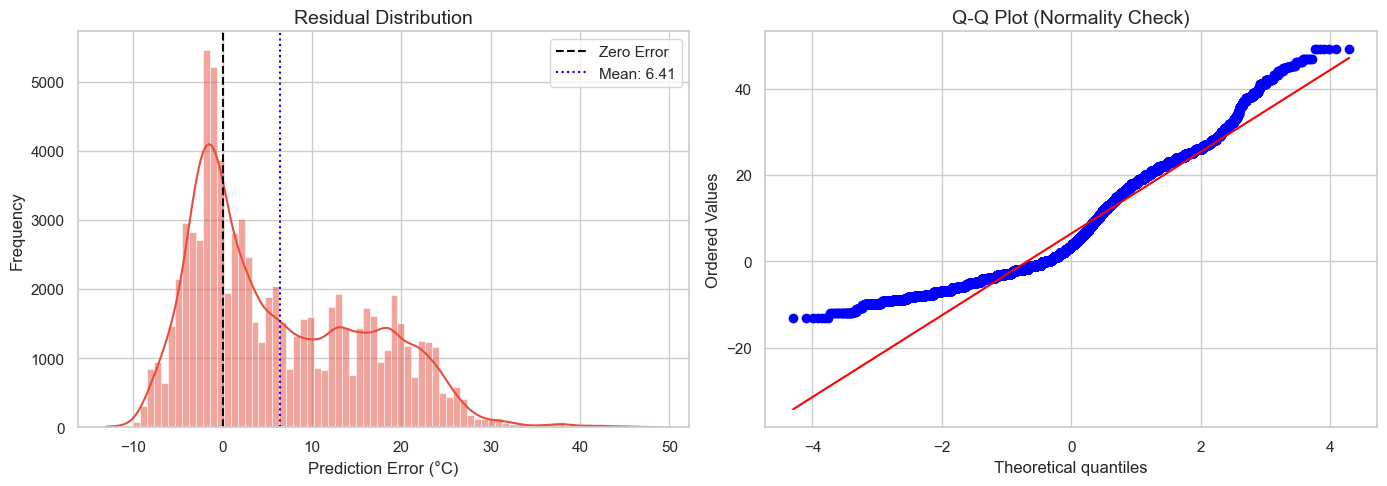

📊 Skewness: 0.670 | Kurtosis: -0.387


In [7]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram
ax1 = axes[0]
sns.histplot(residuals, bins=80, kde=True, color='#E74C3C', ax=ax1)
ax1.axvline(0, color='black', linestyle='--', linewidth=1.5, label='Zero Error')
ax1.axvline(np.mean(residuals), color='blue', linestyle=':', linewidth=1.5, label=f'Mean: {np.mean(residuals):.2f}')
ax1.set_xlabel('Prediction Error (°C)')
ax1.set_ylabel('Frequency')
ax1.set_title('Residual Distribution')
ax1.legend()

# Q-Q Plot
ax2 = axes[1]
stats.probplot(residuals, dist='norm', plot=ax2)
ax2.set_title('Q-Q Plot (Normality Check)')
ax2.get_lines()[1].set_color('red')

plt.tight_layout()
plt.show()

print(f'📊 Skewness: {stats.skew(residuals):.3f} | Kurtosis: {stats.kurtosis(residuals):.3f}')

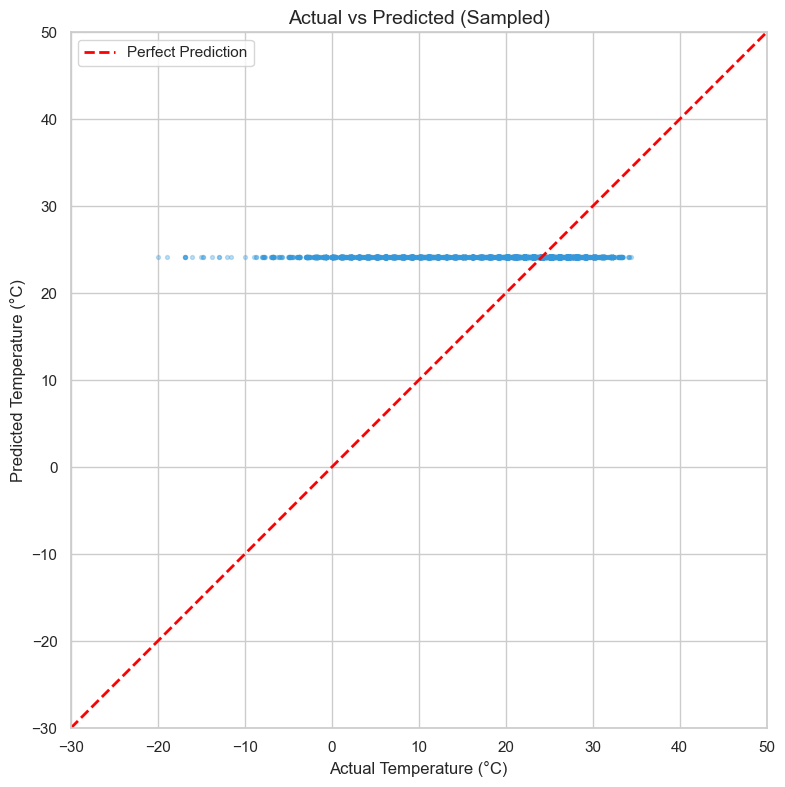

In [8]:
# Actual vs Predicted Scatter
fig, ax = plt.subplots(figsize=(8, 8))

# Sample for performance
sample_idx = np.random.choice(len(y_true), size=min(5000, len(y_true)), replace=False)
ax.scatter(y_true[sample_idx], y_pred[sample_idx], alpha=0.3, s=8, c='#3498DB')

# Perfect prediction line
lims = [-30, 50]
ax.plot(lims, lims, 'r--', linewidth=2, label='Perfect Prediction')

ax.set_xlim(lims)
ax.set_ylim(lims)
ax.set_xlabel('Actual Temperature (°C)')
ax.set_ylabel('Predicted Temperature (°C)')
ax.set_title('Actual vs Predicted (Sampled)')
ax.legend()
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

---
## 5️⃣ Forecast Horizon Analysis
How does accuracy degrade from Day 1 → Day 7?

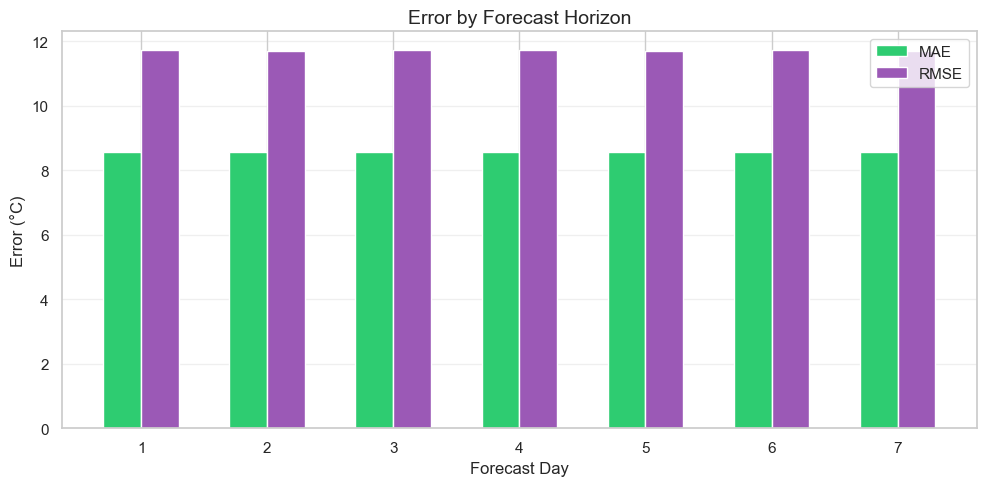

📉 Day 1 MAE: 8.58°C → Day 7 MAE: 8.57°C


In [9]:
# MAE per forecast day
horizon_mae = [np.mean(np.abs(preds[:, d] - y_seq[:, d])) for d in range(PRED_LEN)]
horizon_rmse = [np.sqrt(np.mean((preds[:, d] - y_seq[:, d]) ** 2)) for d in range(PRED_LEN)]

fig, ax = plt.subplots(figsize=(10, 5))
days = np.arange(1, PRED_LEN + 1)

ax.bar(days - 0.15, horizon_mae, width=0.3, label='MAE', color='#2ECC71')
ax.bar(days + 0.15, horizon_rmse, width=0.3, label='RMSE', color='#9B59B6')

ax.set_xlabel('Forecast Day')
ax.set_ylabel('Error (°C)')
ax.set_title('Error by Forecast Horizon')
ax.set_xticks(days)
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(f'📉 Day 1 MAE: {horizon_mae[0]:.2f}°C → Day 7 MAE: {horizon_mae[-1]:.2f}°C')

---
## 6️⃣ Sample Forecast Visualizations

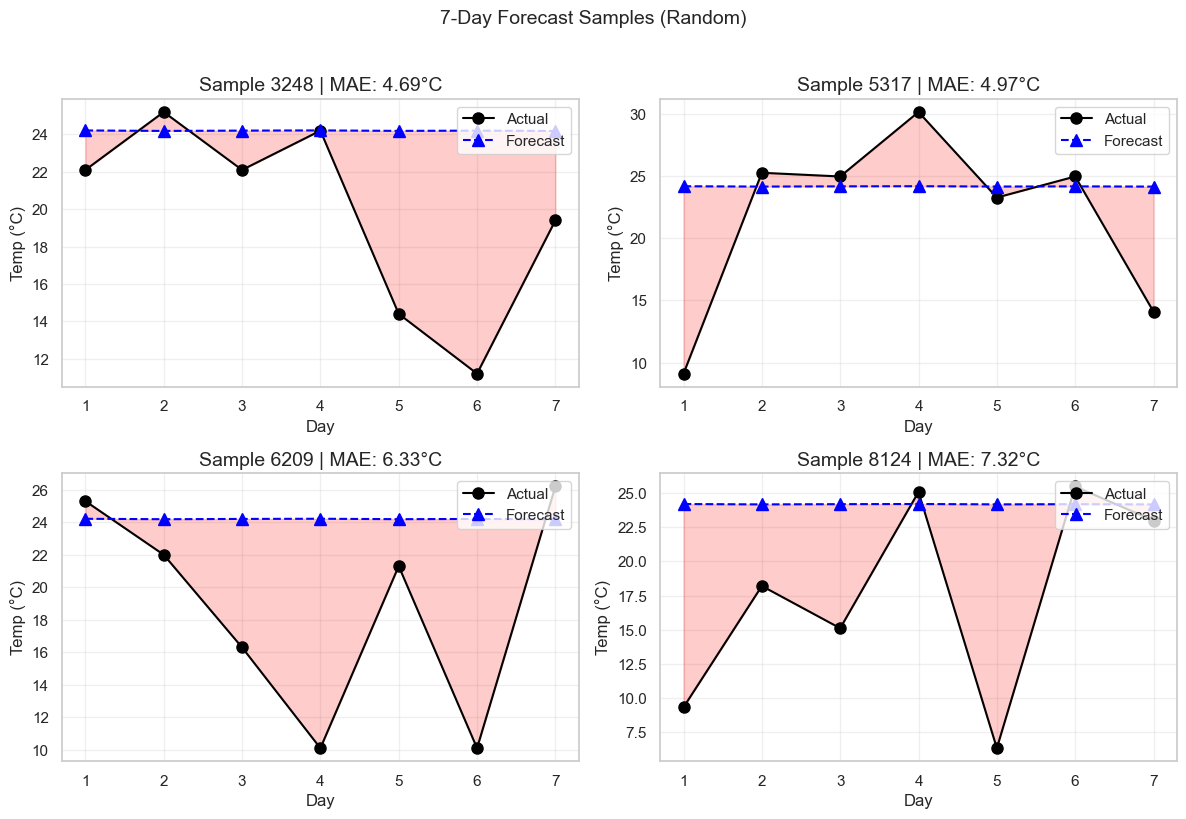

In [10]:
# Show 4 random forecast samples
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
days = np.arange(1, PRED_LEN + 1)

for ax in axes.flatten():
    idx = np.random.randint(0, len(y_seq))
    ax.plot(days, y_seq[idx], 'ko-', label='Actual', markersize=8)
    ax.plot(days, preds[idx], 'b^--', label='Forecast', markersize=8)
    ax.fill_between(days, y_seq[idx], preds[idx], alpha=0.2, color='red')
    sample_mae = np.mean(np.abs(preds[idx] - y_seq[idx]))
    ax.set_title(f'Sample {idx} | MAE: {sample_mae:.2f}°C')
    ax.set_xlabel('Day')
    ax.set_ylabel('Temp (°C)')
    ax.legend(loc='upper right')
    ax.grid(alpha=0.3)

plt.suptitle('7-Day Forecast Samples (Random)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

---
## 7️⃣ Feature Importance (GRN Weight Analysis)
The GRN's first layer weights indicate which features the model prioritizes.

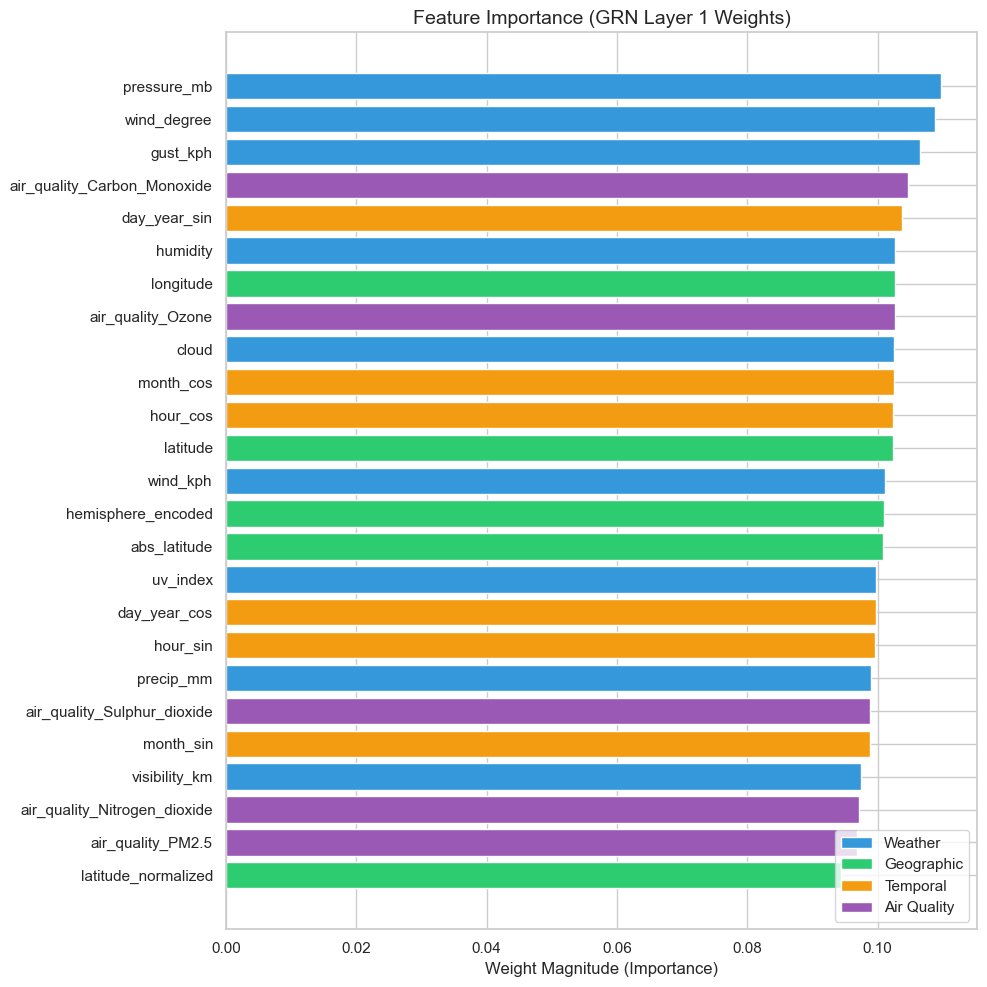

In [11]:
# Extract weights from input GRN
fc1_weights = model.input_grn.fc1.weight.detach().cpu().numpy()  # (hidden, input)
gate_weights = model.input_grn.gate.weight.detach().cpu().numpy()

# Importance = avg absolute weight magnitude
fc1_importance = np.mean(np.abs(fc1_weights), axis=0)
gate_importance = np.mean(np.abs(gate_weights), axis=0)[:len(FEATURE_COLS)]  # Gate is on hidden, so this is indirect

# Combined importance
importance = fc1_importance

# Create DataFrame and sort
imp_df = pd.DataFrame({'Feature': FEATURE_COLS, 'Importance': importance})
imp_df = imp_df.sort_values('Importance', ascending=True)  # Ascending for horizontal bar

# Color by category
def get_category(f):
    if 'air_quality' in f: return 'Air Quality'
    if any(x in f for x in ['sin', 'cos', 'month', 'day', 'hour']): return 'Temporal'
    if any(x in f for x in ['lat', 'lon', 'hemisphere']): return 'Geographic'
    return 'Weather'

imp_df['Category'] = imp_df['Feature'].apply(get_category)
colors = {'Weather': '#3498DB', 'Geographic': '#2ECC71', 'Temporal': '#F39C12', 'Air Quality': '#9B59B6'}

fig, ax = plt.subplots(figsize=(10, 10))
bars = ax.barh(imp_df['Feature'], imp_df['Importance'], color=[colors[c] for c in imp_df['Category']])
ax.set_xlabel('Weight Magnitude (Importance)')
ax.set_title('Feature Importance (GRN Layer 1 Weights)')

# Legend
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=l) for l, c in colors.items()]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

---
## 8️⃣ Robustness Test: Missing Air Quality Inputs
Simulate what happens when users don't provide Tier 3 (optional) inputs.

In [12]:
# Identify Air Quality columns
aq_cols = [c for c in FEATURE_COLS if 'air_quality' in c]
aq_indices = [FEATURE_COLS.index(c) for c in aq_cols]
print(f'🧪 Testing robustness by zeroing: {aq_cols}')

# Corrupt test set (zero out AQ features)
X_test_corrupt = X_test.copy()
for i in aq_indices:
    X_test_corrupt[:, i] = 0.0

X_seq_c, _ = create_sequences(X_test_corrupt, y_test, SEQ_LEN, PRED_LEN)

# Predict on corrupted data
preds_corrupt = []
with torch.no_grad():
    for i in range(0, len(X_seq_c), BATCH_SIZE):
        batch = torch.FloatTensor(X_seq_c[i:i+BATCH_SIZE]).to(device)
        preds_corrupt.append(model(batch).cpu().numpy())
preds_corrupt = np.concatenate(preds_corrupt)

# Compare
mae_original = np.mean(np.abs(preds - y_seq))
mae_corrupt = np.mean(np.abs(preds_corrupt - y_seq))
degradation = mae_corrupt - mae_original
degradation_pct = (degradation / mae_original) * 100

print(f'\n📊 Results:')
print(f'   Original MAE:    {mae_original:.2f}°C')
print(f'   No-AQ MAE:       {mae_corrupt:.2f}°C')
print(f'   Degradation:     {degradation:+.2f}°C ({degradation_pct:+.1f}%)')

if abs(degradation_pct) < 5:
    print('\n✅ Model is ROBUST to missing Air Quality inputs!')
else:
    print('\n⚠️ Model shows degradation without Air Quality inputs.')

🧪 Testing robustness by zeroing: ['air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_PM2.5', 'air_quality_Carbon_Monoxide', 'air_quality_Sulphur_dioxide']

📊 Results:
   Original MAE:    8.58°C
   No-AQ MAE:       8.58°C
   Degradation:     -0.00°C (-0.0%)

✅ Model is ROBUST to missing Air Quality inputs!


---
## ✅ Analysis Summary

| Aspect | Finding |
|--------|---------|  
| **Global MAE** | Run cells above to see |
| **Horizon Degradation** | Check if Day 7 is significantly worse than Day 1 |
| **Error Distribution** | Check Q-Q plot for normality |
| **Missing AQ Robustness** | Check if degradation < 5% |

**Next Steps**:  
- If MAE is high → Consider feature engineering or hyperparameter tuning via CI/CD  
- If robustness fails → Add feature masking augmentation during training  
- Graduate code to `src/v3/` for production deployment